# LinearRegression и LogisticRegression

Реализовать 2 класса LinearRegression и LogisticRegression

In [1]:
import math
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

### Вспомогательная функция отрисовки представления результатов алгоритма

x - входной вектор параметров  
y - реальные значения предсказываемой величины  
p - предсказанные значения величины

In [2]:
def PrintGraph(x, y, p):
    if (len(x.shape) == 1):
        plt.figure(1)
        plt.plot(x, y, marker='o', color='red', ls='')
        plt.plot(x, p, color='blue')
        plt.show()
    elif (x.shape[1] == 2):
        fig = plt.figure()
        plt.grid(True)
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(x[:, 0], x[:, 1], y, c='r', marker='^')
        ax.plot(x[:, 0], x[:, 1], p, c='b')
        plt.show()
    else:
        print x[:, 0], x[:, 1], y
        print x[:, 0], x[:, 1], p
        print

## Подготовка данных

### Одномерный случай

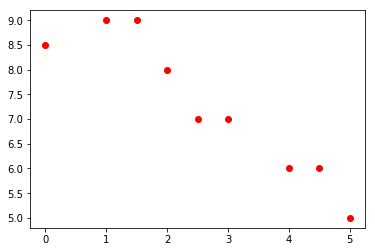

In [3]:
X = np.array([0, 1, 2, 3, 4, 5, 1.5, 2.5, 4.5])
Y = np.array([8.5, 9, 8, 7, 6, 5,   9,   7,   6])

plt.figure(1)
plt.plot(X, Y, marker='o', color='red', ls='')
plt.show()

### Двумерный случай

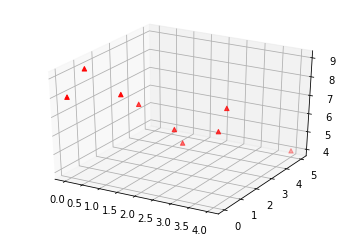

In [4]:
A = np.array([[0, 0], [0, 1], [1, 1], [1, 2], [2, 2], [2, 2.5], [3, 2.5], [3, 3], [4, 5]])
B = np.array([     8,      9,      8,      7,      6,        5,        6,      7,      4])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(A[:, 0], A[:, 1], B, c='r', marker='^')
plt.show()

### Двумерный случай для классификации

(2 линейно не разделимых класса объектов)

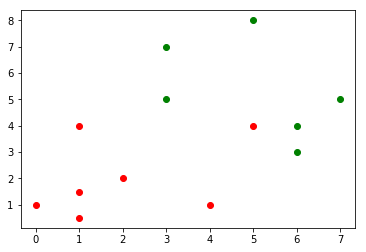

In [5]:
M = np.array([[0, 1], [1, 1.5], [1, 0.5], [6, 3], [4, 1], [5, 8], [6, 4], [7, 5], [3, 7], [2, 2], [1, 4], [3,5], [5, 4]])
N = np.array([     0,        0,        0,      1,      0,      1,      1,      1,      1, 0, 0, 1, 0])

plt.figure(1)
for i in range(M.shape[0]):
    clr = 'green'
    if (N[i] == -1 or N[i] == 0):
        clr = 'red'
    plt.plot(M[i][0], M[i][1], marker='o', color=clr, ls='')
plt.show()

## Линейная регрессия (LinearRegression)

Функция потерь для линейной регрессии:  
  
$$Q = \frac{1}{n} \sum_{i=0}^{n-1} (y_{i} - (w_{0}x_{i} + w_{1}x_{i} + ... + w_{d-1}x_{i} + w_{d}))^{2}$$

Частная производная функции потерь по $w_{k} \neq w_{d}$:  
  
$$\frac{\partial Q}{\partial w_{k}} = \frac{2}{n} \sum_{i=0}^{n-1} ((w_{0}x_{i} + w_{1}x_{i} + ... + w_{d-1}x_{i} + w_{d}) - y_{i}) x_{i}$$

Частная производная функции потерь по $w_{d}$:  
  
$$\frac{\partial Q}{\partial w_{d}} = \frac{2}{n} \sum_{i=0}^{n-1} ((w_{0}x_{i} + w_{1}x_{i} + ... + w_{d-1}x_{i} + w_{d}) - y_{i}) $$

Вычисление нового веса:
$$ w_{k-new} = w_{k} - \eta \frac{\partial Q}{\partial w_{k}} $$

In [6]:
class LinearRegression():
    
    def __init__(self, learning_rate=1, change_rate=True, xkf=50, max_iter=100, eps=0.01, print_int=100):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.change_rate = change_rate
        self.xkf = xkf
        self.eps = eps
        self.print_int = print_int
        self.w = None
        self.iter = 0
        
    def fit(self, x, y):
        
        d = 1
        if (len(x.shape) != 1): # Если не одномерный случай
            d = x.shape[1]      # Количество измерений (атрибутов)
        n = x.shape[0]          # Количество элементов (точек)
        
        u = self.learning_rate  # Коэффициент шага (переменный)
        t = 0                   # Номер итерации
        
        work = True
        
        w = np.array([0.0 for _ in range(d+1)]) # Веса, d-й является свободным
        
        while (work):
            t += 1
            if (self.change_rate):
                u = self.learning_rate / (t/self.xkf + 1)
            
            dQ = np.array([0.0 for _ in range(d+1)])
            
            for k in range(d+1):
                for i in range(n):
                    s = 0.0
                    if (d == 1):
                        s += x[i] * w[0]
                    else:
                        for j in range(d):
                            s += x[i][j] * w[j]
                    s += w[d]
                    s -= y[i]
                    if (k < d):
                        if (d == 1):
                            s *= x[i]
                        else:
                            s *= x[i][k]
                    dQ[k] += s
                dQ[k] *= (2/float(n))
            
            w = w - u * dQ
            
            p = np.array([0.0 for _ in range(n)])
            
            for i in range(n):
                if (d == 1):
                    p[i] += x[i] * w[0]
                else:
                    for j in range(d):
                        p[i] += x[i][j] * w[j]
                p[i] += w[d]
            
            if (t >= self.max_iter or np.all(np.absolute(u * dQ) <= self.eps)):
                work = False
            
            if (self.print_int != 0 and (t % self.print_int == 0 or t == 1)):
                PrintGraph(x, y, p)
                
        self.iter = t
        self.w = w
        return self
    
    def predict(self, x):
        p = np.array([0.0 for _ in range(x.shape[0])])
        for i in range(x.shape[0]):
            if (len(x.shape) == 1):
                p[i] = x[i] * self.w[0] + self.w[1]
            else:
                for j in range(x.shape[1]):
                    p[i] += x[i][j] * self.w[j]
                p[i] += self.w[x.shape[1]]
        return p

### Аппроксимация данных (одномерный случай, без изменяемого шага)

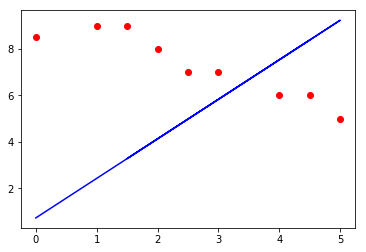

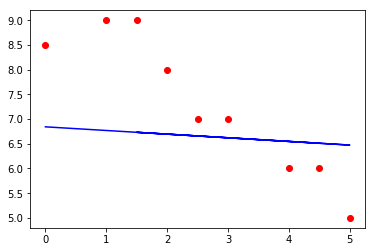

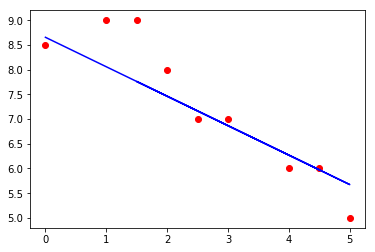

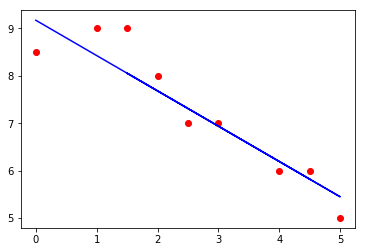

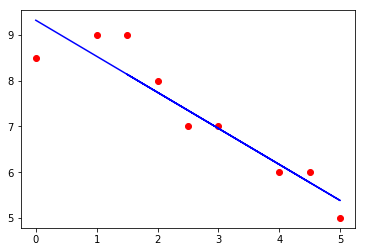

I = 217


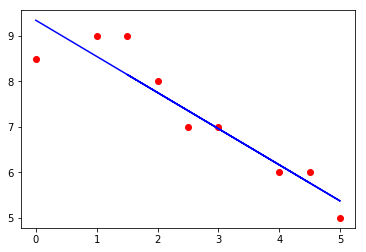

In [7]:
clf = LinearRegression(learning_rate=0.05, change_rate=False, max_iter=300, eps=0.001, print_int=50)
clf.fit(X, Y)
print 'I =', clf.iter
pr = clf.predict(X)
PrintGraph(X, Y, pr)

### Аппроксимация данных (одномерный случай, изменяемый шаг)

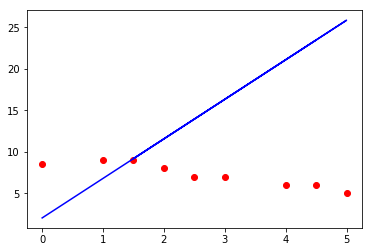

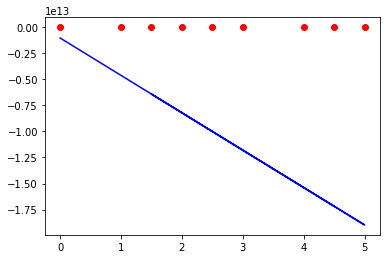

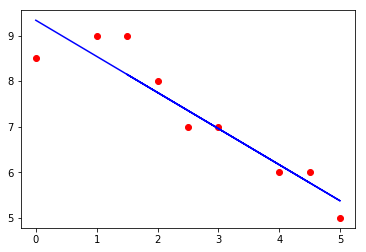

I = 103


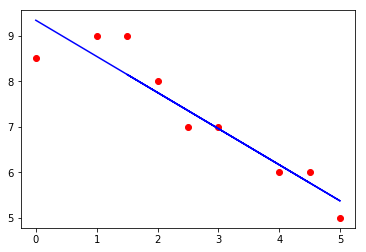

In [8]:
clf = LinearRegression(learning_rate=0.14, change_rate=True, max_iter=300, eps=0.001, print_int=50)
clf.fit(X, Y)
print 'I =', clf.iter
pr = clf.predict(X)
PrintGraph(X, Y, pr)

### Аппроксимация данных (двумерный случай, без изменяемого шага)

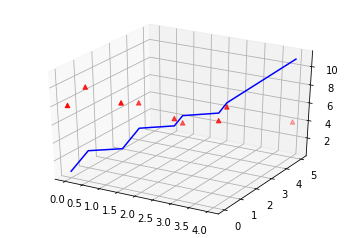

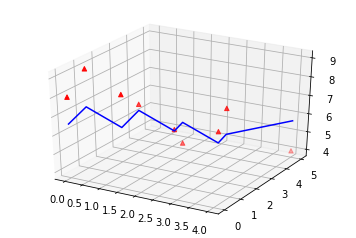

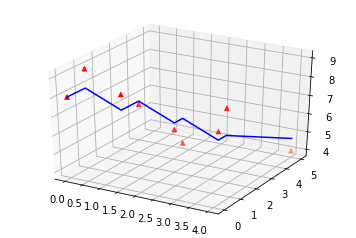

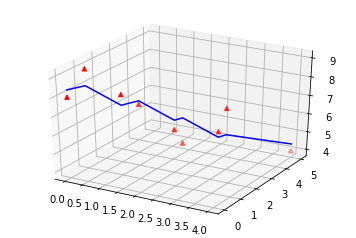

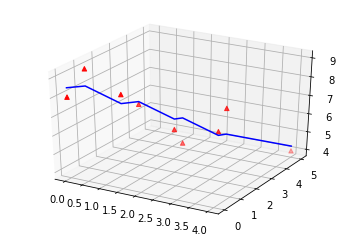

I = 249


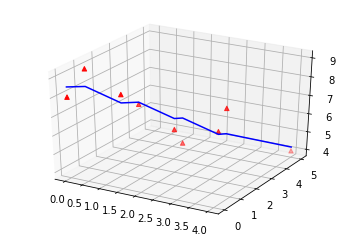

In [9]:
clf = LinearRegression(learning_rate=0.05, change_rate=False, max_iter=300, eps=0.001, print_int=50)
clf.fit(A, B)
print 'I =', clf.iter
pr = clf.predict(A)
PrintGraph(A, B, pr)

### Аппроксимация данных (двумерный случай, изменяемый шаг)

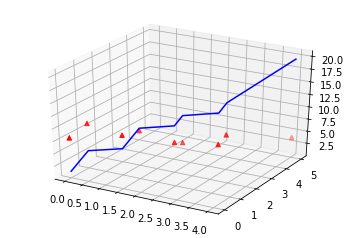

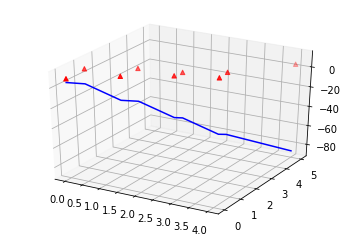

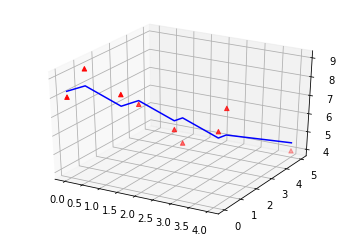

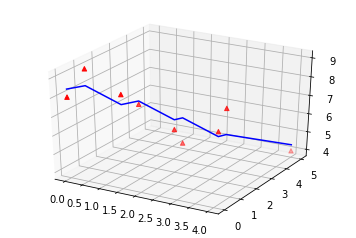

I = 199


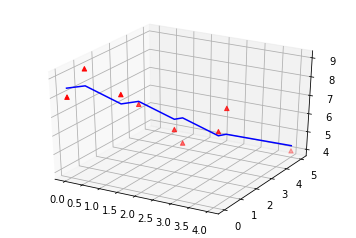

In [10]:
clf = LinearRegression(learning_rate=0.09, change_rate=True, max_iter=300, eps=0.001, print_int=50)
clf.fit(A, B)
print 'I =', clf.iter
pr = clf.predict(A)
PrintGraph(A, B, pr)

### Основные соотношения для логистической регрессии

$$ \sigma (x) = \frac{1}{1 + e^{-x}} $$

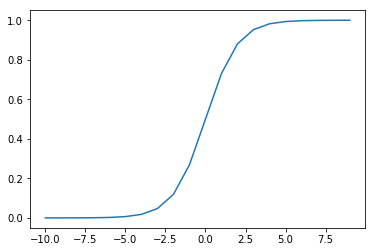

In [11]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

p = np.array([sigmoid(i) for i in range(-10, 10, 1)])
plt.plot(range(-10, 10, 1), p)
plt.show()

$$ z(x) = w_{0} x + w_{1} x + ... + w_{d-1} x + w_{d} $$

Функция потерь для логистической регрессии:  
$$ C = \frac{1}{n} \sum_{i=0}^{n-1} (y_{i}   ln(\sigma (z)) + (1-y_{i}) ln(1-\sigma (z))) $$

Частная производная функции потерь по $w_{k} \neq w_{d}$:  
$$ \frac{\partial C}{\partial w_{k}} = \frac{2}{n} (y_{i} - \sigma (z)) x_{i} $$

Частная производная функции потерь по $w_{d}$:  
$$ \frac{\partial C}{\partial w_{d}} = \frac{2}{n} (y_{i} - \sigma (z)) $$

Вычисление нового веса:
$$ w_{k-new} = w_{k} - \eta \frac{\partial Q}{\partial w_{k}} $$

### Вспомогательная функция отрисовки представления результатов алгоритма

x - входной вектор параметров  
y - реальные значения предсказываемой величины  
w - веса после обучения  
pred - предсказанные значения величины

Маркеры:  
'х' - неверно определен класс  
'o' - верно определен класс  

Цвета:  
зеленые - класс '1'  
красные - класс '0'

In [12]:
def PrintClfGraph(x, y, w, pred, xmin=0, xmax=0):
    
    plt.figure(1)
    
    if (xmin == xmax):
        xmin=np.min(x[:, 0])
        xmax=np.max(x[:, 0])
    
    for i in range(x.shape[0]):   
        clr = 'green'
        mrk = 'x'
        if (y[i] < 0.5):
            clr = 'red'
        if ((y[i] < 0.5) == (pred[i] < 0.5)):
            mrk = 'o'  
        plt.plot(x[i][0], x[i][1], marker=mrk, color=clr, ls='')
        
    p = [0.0, 0.0]
    p[1] = - (w[2] + w[0] * xmax) / w[1]
    p[0] = - (w[2] + w[0] * xmin) / w[1]

    plt.plot([xmin, xmax], p, color='b')
    plt.show()

## Логистическая регрессия (LogisticRegression)

In [13]:
class LogisticRegression():
    
    def __init__(self,learning_rate=0.1,change_rate=True,xkf=50,max_iter=100,eps=0.01,print_int=10,pminx=0,pmaxx=0):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.change_rate = change_rate
        self.xkf = xkf
        self.eps = eps
        self.pminx = pminx
        self.pmaxx = pmaxx
        self.print_int = print_int
        self.w = None
        self.iter = 0
        
    def fit(self, x, y):
        
        d = 1
        if (len(x.shape) != 1): # Если не одномерный случай
            d = x.shape[1]      # Количество измерений (атрибутов)
        n = x.shape[0]          # Количество элементов (точек)
        
        u = self.learning_rate  # Коэффициент шага (переменный)
        t = 0                   # Номер итерации
        
        work = True
        
        w = np.array([0.0 for _ in range(d+1)]) # Веса, d-й является свободным
        
        while (work):
            t += 1
            if (self.change_rate):
                u = self.learning_rate / (t/self.xkf + 1)
            
            dQ = np.array([0.0 for _ in range(d+1)])
            
            for k in range(d+1):
                for i in range(n):
                    s = 0.0
                    if (d == 1):
                        s += x[i] * w[0]
                    else:
                        for j in range(d):
                            s += x[i][j] * w[j]
                    s += w[d]
                    s = sigmoid(s) - y[i]
                    if (k < d):
                        if (d == 1):
                            s *= x[i]
                        else:
                            s *= x[i][k]
                    dQ[k] += s
                dQ[k] *= (2/float(n))
            
            w = w - u * dQ
            
            p = np.array([0.0 for _ in range(n)])
            
            for i in range(n):
                if (d == 1):
                    p[i] += x[i] * w[0]
                else:
                    for j in range(d):
                        p[i] += x[i][j] * w[j]
                p[i] += w[d]
                p[i] = sigmoid(p[i])
            
            if (t >= self.max_iter or np.all(np.absolute(u * dQ) <= self.eps)):
                work = False
            
            if (self.print_int != 0 and (t % self.print_int == 0 or t == 1)):
                PrintClfGraph(x, y, w, p, xmin=self.pminx, xmax=self.pmaxx)
                
        self.iter = t
        self.w = w
        return self
    
    def predict(self, x):
        p = np.array([0.0 for _ in range(x.shape[0])])
        for i in range(x.shape[0]):
            if (len(x.shape) == 1):
                p[i] = sigmoid(x[i] * self.w[0] + self.w[1])
            else:
                for j in range(x.shape[1]):
                    p[i] += x[i][j] * self.w[j]
                p[i] += self.w[x.shape[1]]
                p[i] = sigmoid(p[i])
        return p

### Проверка алгоритма на тестовых данных

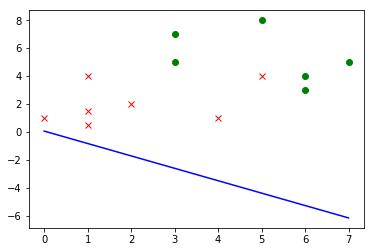

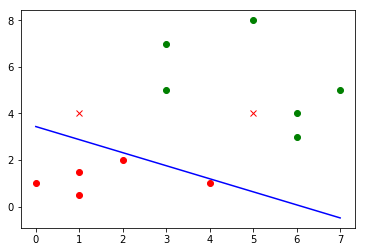

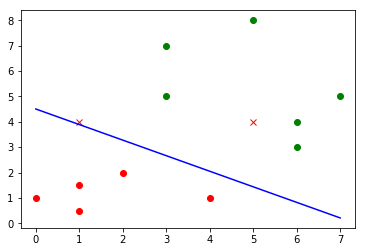

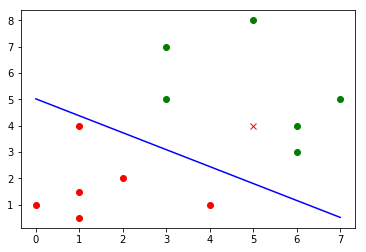

I = 176


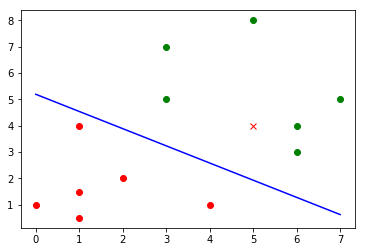

In [14]:
clf = LogisticRegression(learning_rate=0.05, change_rate=False, max_iter=1000, eps=0.008, print_int=50)
clf.fit(M, N)
print 'I =', clf.iter
pr = clf.predict(M)

PrintClfGraph(M, N, clf.w, pr)

## ROC-анализ

In [15]:
def ROC_AUC(p, y):
    print 'ROC-AUC score =', roc_auc_score(y_score=p, y_true=y)
    fpr, tpr, _ = metrics.roc_curve(y_score=p, y_true=y)
    plt.plot(fpr, tpr)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC-curve')
    plt.show()

### ROC-AUC для всей выборки

ROC-AUC score = 0.952380952381


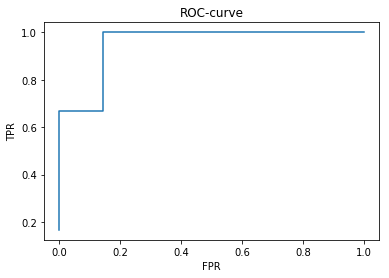

In [16]:
ROC_AUC(clf.predict(M), N)

### ROC-AUC для разбиений выборки

ROC-AUC score = 0.916666666667


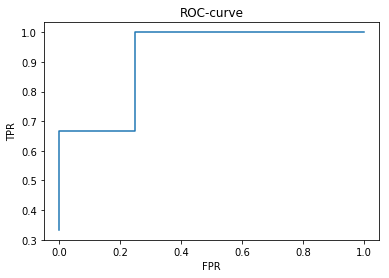

ROC-AUC score = 0.777777777778


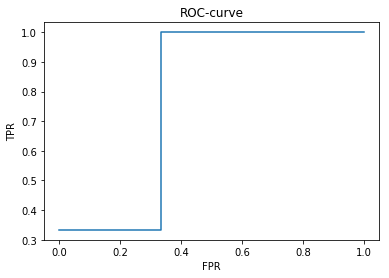

In [17]:
gkf = KFold(n_splits=2, shuffle=True)

learner = LogisticRegression(learning_rate=0.05, change_rate=False, max_iter=1000, eps=0.01, print_int=0)

for train, test in gkf.split(M, N):
    X_train, y_train = M[train], N[train]
    X_test, y_test = M[test], N[test]
    learner.fit(X_train, y_train)
    pr = learner.predict(X_test)
    ROC_AUC(pr, y_test)

### Тестирование на большой выборке (по частям)

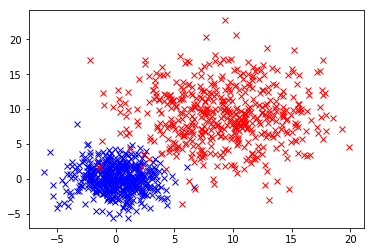

In [18]:
rst = np.random.RandomState(1)
a = rst.normal(0, 2, 1000)
a = a.reshape(500, 2)
b = rst.normal(0, 4, 1000)+9
b = b.reshape(500, 2)
x = np.concatenate((a, b), axis=0)
y = np.array([i/500 for i in range(1000)])
for i in range(1000):
    mrk = 'x'
    clr = 'red'
    if (y[i] < 0.5):
        clr = 'blue'
    plt.plot(x[i][0], x[i][1], marker=mrk, color=clr, ls='')
plt.show()

ROC-AUC score = 0.998637015782


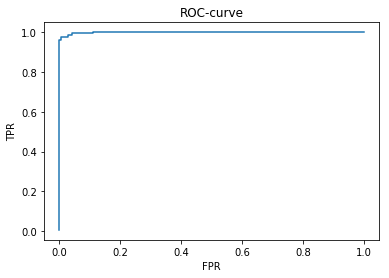

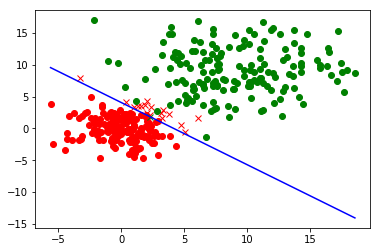

ROC-AUC score = 0.996932515337


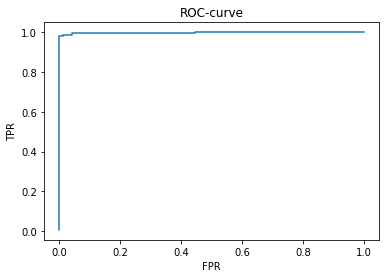

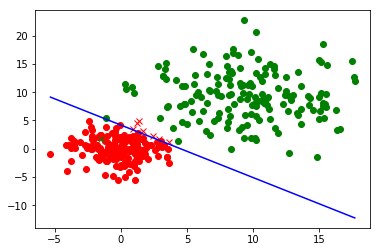

ROC-AUC score = 0.998880057803


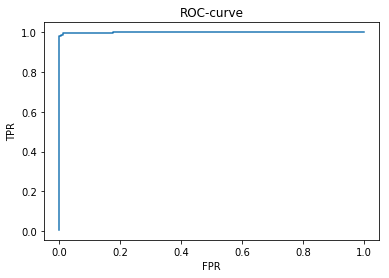

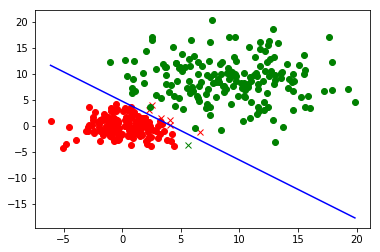

In [19]:
gkf = KFold(n_splits=3, shuffle=True)

learner = LogisticRegression(learning_rate=0.05, change_rate=False, max_iter=1000, eps=0.01, print_int=0)

for train, test in gkf.split(x, y):
    X_train, y_train = x[train], y[train]
    X_test, y_test = x[test], y[test]
    learner.fit(X_train, y_train)
    y_pred = learner.predict(X_test)
    ROC_AUC(y_pred, y_test)
    PrintClfGraph(X_test, y_test, learner.w, y_pred)

### Использование большой выборки целиком

ROC-AUC score = 0.998064


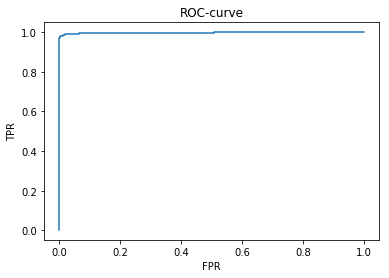

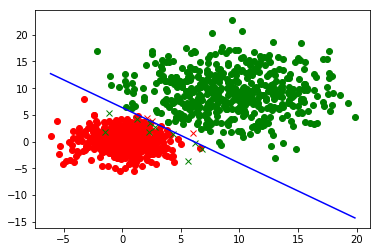

In [20]:
learner = LogisticRegression(learning_rate=0.05, change_rate=False, max_iter=1000, eps=0.001, print_int=0)

learner.fit(x, y)
y_pred = learner.predict(x)
ROC_AUC(y_pred, y)
PrintClfGraph(x, y, learner.w, y_pred)

### Тестирование на средней выборке

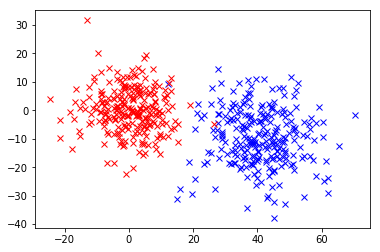

In [21]:
rst = np.random.RandomState(1)
a = rst.normal(-10, 10, 500)
a = a.reshape(250, 2)
a[:, 0] = a[:, 0]+50
b = rst.normal(0, 8, 500)
b = b.reshape(250, 2)
x = np.concatenate((a, b), axis=0)
y = np.array([i/250 for i in range(500)])
for i in range(500):
    mrk = 'x'
    clr = 'red'
    if (y[i] < 0.5):
        clr = 'blue'
    plt.plot(x[i][0], x[i][1], marker=mrk, color=clr, ls='')
plt.show()

ROC-AUC score = 0.999344


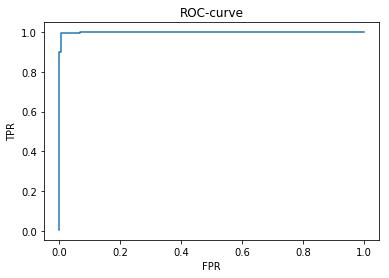

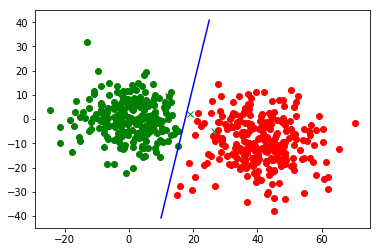

In [22]:
learner = LogisticRegression(learning_rate=0.05, change_rate=False, max_iter=1000, eps=0.001, print_int=0)

learner.fit(x, y)
y_pred = learner.predict(x)
ROC_AUC(y_pred, y)
PrintClfGraph(x, y, learner.w, y_pred, 10, 25)